   loudness  speechiness  liveness
0  3.850998     0.042005  0.108854
1  3.846140     0.025473  0.092944
2  3.770160     0.031789  0.085719
3  3.855516     0.035657  0.076683
4  3.945052     0.029753  0.104360
   loudness  speechiness  acousticness  instrumentalness  liveness     tempo
0 -0.166869    -0.492201      1.147796         -0.626797 -0.532718  0.390669
1 -0.202018    -0.729441      0.509017         -0.626758 -0.649071  0.617692
2 -0.751673    -0.638799      0.099845         -0.626654 -0.701906  0.605965
3 -0.134186    -0.583303      1.480432         -0.626797 -0.767982  2.788040
4  0.513533    -0.668021     -0.681409         -0.571627 -0.565585  1.679162
Mean Squared Error (MSE): 0.17
R-squared (R2): 0.13
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 11, 'min_samples_split': 2}


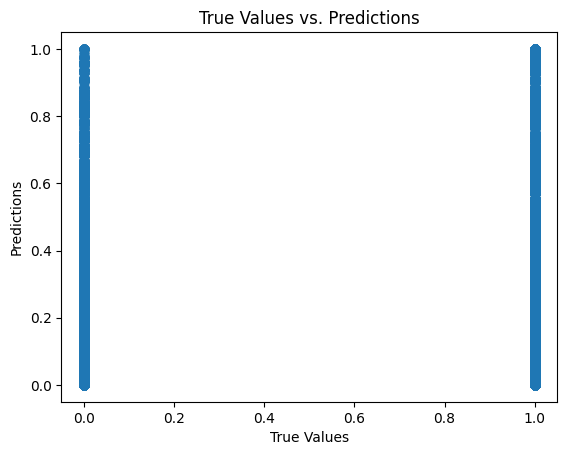

In [4]:
# 決策樹回歸
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from google.colab import files
import io
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import graphviz 
import os
from sklearn.preprocessing import StandardScaler

a_url = 'C:/Users/User/Downloads/processed_data.csv'
one_m_data = pd.read_csv(a_url)

one_m_data['audio_mode'] = one_m_data['mode']
one_m_data.audio_mode= one_m_data.audio_mode.astype(float)

threshold = one_m_data['popularity'].quantile(0.75)

# 選擇人氣度前25%的歌曲
top_25p_songs = one_m_data[one_m_data['popularity'] >= threshold]

# num_of_songs = len(top_25p_songs)
# num_of_songs

# 選擇人氣度後75%的歌曲
random_seed = 42
bot_75p_songs = one_m_data[one_m_data['popularity'] < threshold]

# 從人氣度後75%的歌曲中隨機挑選與前25%數量相同的歌曲
random_seed = 42
sam_75p_songs = bot_75p_songs.sample(n=len(top_25p_songs))

# 合併上述兩個子集以創建新的DataFrame
one_m_data = pd.concat([top_25p_songs, sam_75p_songs], axis=0).reset_index(drop=True)

# one_m_data.shape

# 要取對數的特征列表
features_to_log = ['loudness', 'speechiness', 'liveness']

# 為了避免負值和零，對 loudness 進行正值轉換，因為它可能有負值
one_m_data['loudness'] = one_m_data['loudness'] - one_m_data['loudness'].min() + 1
one_m_data['speechiness'] = one_m_data['speechiness'] - one_m_data['speechiness'].min() + 1
one_m_data['liveness'] = one_m_data['liveness'] - one_m_data['liveness'].min() + 1

# 對這些特徵取對數，並在取對數之前加上一個很小的正數
epsilon = 1e-10
for feature in features_to_log:
    one_m_data[feature] = np.log(one_m_data[feature] + epsilon)

# 顯示轉換後的特徵的前幾行
print(one_m_data[features_to_log].head())

# Features to standardize
features_to_standardize = ['loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the standardization to the f_engineering dataframe
one_m_data[features_to_standardize] = scaler.fit_transform(one_m_data[features_to_standardize])

# Display the first few rows of the standardized features
print(one_m_data[features_to_standardize].head())

one_m_data["popularity"]= [ 1 if i>=40 else 0 for i in one_m_data.popularity ]
one_m_data["popularity"].value_counts()

one_m_data["key"] = one_m_data["key"].astype("category")
one_m_data = pd.get_dummies(one_m_data, columns=["key"])
one_m_data["key_0"] = one_m_data["key_0"].astype(int)
one_m_data["key_1"] = one_m_data["key_1"].astype(int)
one_m_data["key_2"] = one_m_data["key_2"].astype(int)
one_m_data["key_3"] = one_m_data["key_3"].astype(int)
one_m_data["key_4"] = one_m_data["key_4"].astype(int)
one_m_data["key_5"] = one_m_data["key_5"].astype(int)
one_m_data["key_6"] = one_m_data["key_6"].astype(int)
one_m_data["key_7"] = one_m_data["key_7"].astype(int)
one_m_data["key_8"] = one_m_data["key_8"].astype(int)
one_m_data["key_9"] = one_m_data["key_9"].astype(int)
one_m_data["key_10"] = one_m_data["key_10"].astype(int)
one_m_data["key_11"] = one_m_data["key_11"].astype(int)
one_m_data.head()

one_m_data["audio_mode"] = one_m_data["audio_mode"].astype("category")
one_m_data = pd.get_dummies(one_m_data, columns=["audio_mode"])
one_m_data["audio_mode_0.0"] = one_m_data["audio_mode_0.0"].astype(int)
one_m_data["audio_mode_1.0"] = one_m_data["audio_mode_1.0"].astype(int)
one_m_data.head()

one_m_data.drop(['year','mode'],axis=1,inplace=True)
one_m_data.columns[one_m_data.isnull().any()]

y = one_m_data["popularity"].values
X = one_m_data.drop(["popularity"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 12, 14, 16, 18],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [3, 5, 7, 9, 11]
}

grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

grid_search.fit(X_train_scaled, y_train)

best_regressor = grid_search.best_estimator_

y_pred = best_regressor.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("Best Parameters:", grid_search.best_params_)

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")
plt.show()

# 尚未切分資料集前的結果
# 決策樹回歸的效果非常差
# Best Parameters: {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 10}
# max_depth=5 : 
# Mean Squared Error (MSE): 207.28
# R-squared (R2): 0.11

# max_depth=10 :
# Mean Squared Error (MSE): 192.49
# R-squared (R2): 0.18
    
# max_depth=2 :
# Mean Squared Error (MSE): 217.72
# R-squared (R2): 0.07

# max_depth=20
# Mean Squared Error (MSE): 217.71
# R-squared (R2): 0.07

# max_depth=11
# Mean Squared Error (MSE): 190.22
# R-squared (R2): 0.19

# max_depth=12
# Mean Squared Error (MSE): 188.69
# R-squared (R2): 0.19

# max_depth=13
# Mean Squared Error (MSE): 188.13
# R-squared (R2): 0.19

# max_depth=14
# Mean Squared Error (MSE): 188.41
# R-squared (R2): 0.19

# max_depth=9
# Mean Squared Error (MSE): 194.73
# R-squared (R2): 0.17

# param_grid = {
#     'max_depth': [9, 10, 11, 12, 13, 14, 15, 16, 17],
#     'min_samples_split': [7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
# }
# Mean Squared Error (MSE): 186.45
# R-squared (R2): 0.20
# Best Parameters: {'max_depth': 14, 'min_samples_leaf': 9, 'min_samples_split': 7}

# param_grid = {
#     'max_depth': [18, 20, 22, 24],
#     'min_samples_split': [8, 10, 12, 14],
#     'min_samples_leaf': [3, 5, 7, 9]
# }
# Mean Squared Error (MSE): 192.22
# R-squared (R2): 0.18
# Best Parameters: {'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 8}

# 切分資料集後的結果
# param_grid = {
#     'max_depth': [10, 12, 14, 16, 18],
#     'min_samples_split': [2, 4, 6, 8, 10],
#     'min_samples_leaf': [3, 5, 7, 9, 11]
# }
# Mean Squared Error (MSE): 224.38
# R-squared (R2): 0.21
# Best Parameters: {'max_depth': 12, 'min_samples_leaf': 11, 'min_samples_split': 2}